# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 983us/sample - loss: 242.7125 - y1_output_loss: 116.6850 - y2_output_loss: 123.8783 - y1_output_root_mean_squared_error: 10.8499 - y2_output_root_mean_squared_error: 11.1800 - val_loss: 58.5601 - val_y1_output_loss: 15.4450 - val_y2_output_loss: 41.4051 - val_y1_output_root_mean_squared_error: 3.9997 - val_y2_output_root_mean_squared_error: 6.5240
Epoch 2/500
614/614 [==============================] - 0s 143us/sample - loss: 29.4682 - y1_output_loss: 12.2028 - y2_output_loss: 17.1174 - y1_output_root_mean_squared_error: 3.5068 - y2_output_root_mean_squared_error: 4.1438 - val_loss: 30.3262 - val_y1_output_loss: 8.4341 - val_y2_output_loss: 21.0511 - val_y1_output_root_mean_squared_error: 2.9352 - val_y2_output_root_mean_squared_error: 4.6595
Epoch 3/500
614/614 [==============================] - 0s 149us/sample - loss: 26.6684 - y1_output_loss: 10.8252 - y2_output_loss: 15.8250 - y1_

Epoch 42/500
614/614 [==============================] - 0s 134us/sample - loss: 6.5364 - y1_output_loss: 1.9638 - y2_output_loss: 4.5284 - y1_output_root_mean_squared_error: 1.4072 - y2_output_root_mean_squared_error: 2.1346 - val_loss: 8.0475 - val_y1_output_loss: 1.9404 - val_y2_output_loss: 5.8315 - val_y1_output_root_mean_squared_error: 1.4154 - val_y2_output_root_mean_squared_error: 2.4585
Epoch 43/500
614/614 [==============================] - 0s 131us/sample - loss: 7.3520 - y1_output_loss: 2.3302 - y2_output_loss: 4.9992 - y1_output_root_mean_squared_error: 1.5309 - y2_output_root_mean_squared_error: 2.2379 - val_loss: 5.9865 - val_y1_output_loss: 1.6900 - val_y2_output_loss: 4.1850 - val_y1_output_root_mean_squared_error: 1.3187 - val_y2_output_root_mean_squared_error: 2.0610
Epoch 44/500
614/614 [==============================] - 0s 132us/sample - loss: 6.5354 - y1_output_loss: 2.1183 - y2_output_loss: 4.4115 - y1_output_root_mean_squared_error: 1.4574 - y2_output_root_mean_s

Epoch 63/500
614/614 [==============================] - 0s 127us/sample - loss: 4.2958 - y1_output_loss: 1.1837 - y2_output_loss: 3.2761 - y1_output_root_mean_squared_error: 1.0900 - y2_output_root_mean_squared_error: 1.7629 - val_loss: 39.0498 - val_y1_output_loss: 6.5952 - val_y2_output_loss: 32.3039 - val_y1_output_root_mean_squared_error: 2.5647 - val_y2_output_root_mean_squared_error: 5.6984
Epoch 64/500
614/614 [==============================] - 0s 129us/sample - loss: 8.0975 - y1_output_loss: 2.3195 - y2_output_loss: 5.8428 - y1_output_root_mean_squared_error: 1.5271 - y2_output_root_mean_squared_error: 2.4011 - val_loss: 6.6495 - val_y1_output_loss: 2.1709 - val_y2_output_loss: 4.6601 - val_y1_output_root_mean_squared_error: 1.4600 - val_y2_output_root_mean_squared_error: 2.1255
Epoch 65/500
614/614 [==============================] - 0s 134us/sample - loss: 4.2830 - y1_output_loss: 1.2143 - y2_output_loss: 3.0626 - y1_output_root_mean_squared_error: 1.0996 - y2_output_root_mean

Epoch 84/500
614/614 [==============================] - 0s 132us/sample - loss: 3.4713 - y1_output_loss: 0.7864 - y2_output_loss: 2.7284 - y1_output_root_mean_squared_error: 0.8850 - y2_output_root_mean_squared_error: 1.6396 - val_loss: 10.2614 - val_y1_output_loss: 3.5601 - val_y2_output_loss: 6.9339 - val_y1_output_root_mean_squared_error: 1.8757 - val_y2_output_root_mean_squared_error: 2.5968
Epoch 85/500
614/614 [==============================] - 0s 127us/sample - loss: 3.6209 - y1_output_loss: 0.8604 - y2_output_loss: 2.7583 - y1_output_root_mean_squared_error: 0.9316 - y2_output_root_mean_squared_error: 1.6592 - val_loss: 6.3336 - val_y1_output_loss: 0.5516 - val_y2_output_loss: 5.7964 - val_y1_output_root_mean_squared_error: 0.7186 - val_y2_output_root_mean_squared_error: 2.4119
Epoch 86/500
614/614 [==============================] - 0s 126us/sample - loss: 3.6243 - y1_output_loss: 0.8134 - y2_output_loss: 2.7782 - y1_output_root_mean_squared_error: 0.9056 - y2_output_root_mean_

Epoch 105/500
614/614 [==============================] - 0s 134us/sample - loss: 2.9858 - y1_output_loss: 0.6799 - y2_output_loss: 2.3014 - y1_output_root_mean_squared_error: 0.8230 - y2_output_root_mean_squared_error: 1.5194 - val_loss: 2.8194 - val_y1_output_loss: 0.5091 - val_y2_output_loss: 2.3088 - val_y1_output_root_mean_squared_error: 0.7039 - val_y2_output_root_mean_squared_error: 1.5244
Epoch 106/500
614/614 [==============================] - 0s 133us/sample - loss: 2.6483 - y1_output_loss: 0.6229 - y2_output_loss: 2.0152 - y1_output_root_mean_squared_error: 0.7869 - y2_output_root_mean_squared_error: 1.4244 - val_loss: 4.1718 - val_y1_output_loss: 0.5506 - val_y2_output_loss: 3.7523 - val_y1_output_root_mean_squared_error: 0.6972 - val_y2_output_root_mean_squared_error: 1.9198
Epoch 107/500
614/614 [==============================] - 0s 131us/sample - loss: 2.9780 - y1_output_loss: 0.6533 - y2_output_loss: 2.3047 - y1_output_root_mean_squared_error: 0.8105 - y2_output_root_mea

Epoch 146/500
614/614 [==============================] - 0s 125us/sample - loss: 2.1137 - y1_output_loss: 0.5688 - y2_output_loss: 1.5578 - y1_output_root_mean_squared_error: 0.7573 - y2_output_root_mean_squared_error: 1.2411 - val_loss: 6.5406 - val_y1_output_loss: 0.4679 - val_y2_output_loss: 6.3603 - val_y1_output_root_mean_squared_error: 0.6531 - val_y2_output_root_mean_squared_error: 2.4727
Epoch 147/500
614/614 [==============================] - 0s 127us/sample - loss: 1.8618 - y1_output_loss: 0.4077 - y2_output_loss: 1.4381 - y1_output_root_mean_squared_error: 0.6412 - y2_output_root_mean_squared_error: 1.2045 - val_loss: 1.8140 - val_y1_output_loss: 0.3282 - val_y2_output_loss: 1.4728 - val_y1_output_root_mean_squared_error: 0.5603 - val_y2_output_root_mean_squared_error: 1.2248
Epoch 148/500
614/614 [==============================] - 0s 128us/sample - loss: 1.7132 - y1_output_loss: 0.4140 - y2_output_loss: 1.3083 - y1_output_root_mean_squared_error: 0.6441 - y2_output_root_mea

Epoch 187/500
614/614 [==============================] - 0s 125us/sample - loss: 1.2662 - y1_output_loss: 0.2597 - y2_output_loss: 0.9984 - y1_output_root_mean_squared_error: 0.5107 - y2_output_root_mean_squared_error: 1.0027 - val_loss: 1.2918 - val_y1_output_loss: 0.3248 - val_y2_output_loss: 1.0279 - val_y1_output_root_mean_squared_error: 0.5715 - val_y2_output_root_mean_squared_error: 0.9825
Epoch 188/500
614/614 [==============================] - 0s 127us/sample - loss: 1.7563 - y1_output_loss: 0.3580 - y2_output_loss: 1.4002 - y1_output_root_mean_squared_error: 0.5990 - y2_output_root_mean_squared_error: 1.1822 - val_loss: 1.7970 - val_y1_output_loss: 0.4163 - val_y2_output_loss: 1.6036 - val_y1_output_root_mean_squared_error: 0.6205 - val_y2_output_root_mean_squared_error: 1.1883
Epoch 189/500
614/614 [==============================] - 0s 143us/sample - loss: 1.6180 - y1_output_loss: 0.3418 - y2_output_loss: 1.2725 - y1_output_root_mean_squared_error: 0.5780 - y2_output_root_mea

Epoch 228/500
614/614 [==============================] - 0s 132us/sample - loss: 0.9935 - y1_output_loss: 0.2114 - y2_output_loss: 0.7823 - y1_output_root_mean_squared_error: 0.4567 - y2_output_root_mean_squared_error: 0.8859 - val_loss: 2.1853 - val_y1_output_loss: 0.5832 - val_y2_output_loss: 1.7675 - val_y1_output_root_mean_squared_error: 0.7564 - val_y2_output_root_mean_squared_error: 1.2701
Epoch 229/500
614/614 [==============================] - 0s 138us/sample - loss: 1.1917 - y1_output_loss: 0.2434 - y2_output_loss: 1.0012 - y1_output_root_mean_squared_error: 0.4946 - y2_output_root_mean_squared_error: 0.9732 - val_loss: 3.4809 - val_y1_output_loss: 0.3897 - val_y2_output_loss: 3.0746 - val_y1_output_root_mean_squared_error: 0.6285 - val_y2_output_root_mean_squared_error: 1.7567
Epoch 230/500
614/614 [==============================] - 0s 138us/sample - loss: 1.5917 - y1_output_loss: 0.3203 - y2_output_loss: 1.2746 - y1_output_root_mean_squared_error: 0.5641 - y2_output_root_mea

Epoch 269/500
614/614 [==============================] - 0s 128us/sample - loss: 0.8426 - y1_output_loss: 0.2005 - y2_output_loss: 0.6578 - y1_output_root_mean_squared_error: 0.4471 - y2_output_root_mean_squared_error: 0.8017 - val_loss: 2.1031 - val_y1_output_loss: 0.6503 - val_y2_output_loss: 1.4876 - val_y1_output_root_mean_squared_error: 0.7901 - val_y2_output_root_mean_squared_error: 1.2161
Epoch 270/500
614/614 [==============================] - 0s 128us/sample - loss: 1.0247 - y1_output_loss: 0.2035 - y2_output_loss: 0.8336 - y1_output_root_mean_squared_error: 0.4514 - y2_output_root_mean_squared_error: 0.9061 - val_loss: 3.8556 - val_y1_output_loss: 0.1936 - val_y2_output_loss: 3.9422 - val_y1_output_root_mean_squared_error: 0.4322 - val_y2_output_root_mean_squared_error: 1.9154
Epoch 271/500
614/614 [==============================] - 0s 127us/sample - loss: 1.0503 - y1_output_loss: 0.2417 - y2_output_loss: 0.8055 - y1_output_root_mean_squared_error: 0.4893 - y2_output_root_mea

Epoch 310/500
614/614 [==============================] - 0s 125us/sample - loss: 0.9285 - y1_output_loss: 0.2109 - y2_output_loss: 0.7105 - y1_output_root_mean_squared_error: 0.4604 - y2_output_root_mean_squared_error: 0.8465 - val_loss: 1.1064 - val_y1_output_loss: 0.3211 - val_y2_output_loss: 0.7974 - val_y1_output_root_mean_squared_error: 0.5578 - val_y2_output_root_mean_squared_error: 0.8918
Epoch 311/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6653 - y1_output_loss: 0.1570 - y2_output_loss: 0.5192 - y1_output_root_mean_squared_error: 0.3968 - y2_output_root_mean_squared_error: 0.7127 - val_loss: 2.5867 - val_y1_output_loss: 0.6404 - val_y2_output_loss: 1.9699 - val_y1_output_root_mean_squared_error: 0.7833 - val_y2_output_root_mean_squared_error: 1.4047
Epoch 312/500
614/614 [==============================] - 0s 134us/sample - loss: 0.8519 - y1_output_loss: 0.1864 - y2_output_loss: 0.6585 - y1_output_root_mean_squared_error: 0.4336 - y2_output_root_mea

Epoch 351/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7024 - y1_output_loss: 0.1839 - y2_output_loss: 0.5137 - y1_output_root_mean_squared_error: 0.4309 - y2_output_root_mean_squared_error: 0.7189 - val_loss: 0.7577 - val_y1_output_loss: 0.1782 - val_y2_output_loss: 0.6336 - val_y1_output_root_mean_squared_error: 0.4196 - val_y2_output_root_mean_squared_error: 0.7627
Epoch 352/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6814 - y1_output_loss: 0.1615 - y2_output_loss: 0.5142 - y1_output_root_mean_squared_error: 0.4037 - y2_output_root_mean_squared_error: 0.7200 - val_loss: 0.7751 - val_y1_output_loss: 0.1744 - val_y2_output_loss: 0.6531 - val_y1_output_root_mean_squared_error: 0.4125 - val_y2_output_root_mean_squared_error: 0.7778
Epoch 353/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5438 - y1_output_loss: 0.1467 - y2_output_loss: 0.3936 - y1_output_root_mean_squared_error: 0.3828 - y2_output_root_mea

Epoch 392/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4932 - y1_output_loss: 0.1489 - y2_output_loss: 0.3590 - y1_output_root_mean_squared_error: 0.3707 - y2_output_root_mean_squared_error: 0.5965 - val_loss: 1.0842 - val_y1_output_loss: 0.3687 - val_y2_output_loss: 0.7829 - val_y1_output_root_mean_squared_error: 0.5952 - val_y2_output_root_mean_squared_error: 0.8544
Epoch 393/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6143 - y1_output_loss: 0.1721 - y2_output_loss: 0.4464 - y1_output_root_mean_squared_error: 0.4164 - y2_output_root_mean_squared_error: 0.6640 - val_loss: 1.9168 - val_y1_output_loss: 0.1496 - val_y2_output_loss: 1.8849 - val_y1_output_root_mean_squared_error: 0.3817 - val_y2_output_root_mean_squared_error: 1.3308
Epoch 394/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7550 - y1_output_loss: 0.1840 - y2_output_loss: 0.5707 - y1_output_root_mean_squared_error: 0.4295 - y2_output_root_mea

Epoch 433/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4257 - y1_output_loss: 0.1335 - y2_output_loss: 0.2898 - y1_output_root_mean_squared_error: 0.3669 - y2_output_root_mean_squared_error: 0.5395 - val_loss: 0.6569 - val_y1_output_loss: 0.2277 - val_y2_output_loss: 0.4611 - val_y1_output_root_mean_squared_error: 0.4723 - val_y2_output_root_mean_squared_error: 0.6587
Epoch 434/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4250 - y1_output_loss: 0.1187 - y2_output_loss: 0.3053 - y1_output_root_mean_squared_error: 0.3455 - y2_output_root_mean_squared_error: 0.5529 - val_loss: 0.6435 - val_y1_output_loss: 0.1991 - val_y2_output_loss: 0.4731 - val_y1_output_root_mean_squared_error: 0.4391 - val_y2_output_root_mean_squared_error: 0.6713
Epoch 435/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3877 - y1_output_loss: 0.1284 - y2_output_loss: 0.2635 - y1_output_root_mean_squared_error: 0.3568 - y2_output_root_mea

Epoch 474/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4410 - y1_output_loss: 0.1346 - y2_output_loss: 0.3053 - y1_output_root_mean_squared_error: 0.3677 - y2_output_root_mean_squared_error: 0.5530 - val_loss: 1.5146 - val_y1_output_loss: 0.5017 - val_y2_output_loss: 0.9969 - val_y1_output_root_mean_squared_error: 0.7074 - val_y2_output_root_mean_squared_error: 1.0071
Epoch 475/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4353 - y1_output_loss: 0.1464 - y2_output_loss: 0.2858 - y1_output_root_mean_squared_error: 0.3842 - y2_output_root_mean_squared_error: 0.5364 - val_loss: 0.6019 - val_y1_output_loss: 0.1907 - val_y2_output_loss: 0.4520 - val_y1_output_root_mean_squared_error: 0.4230 - val_y2_output_root_mean_squared_error: 0.6503
Epoch 476/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4279 - y1_output_loss: 0.1204 - y2_output_loss: 0.3061 - y1_output_root_mean_squared_error: 0.3484 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 34us/sample - loss: 1.6144 - y1_output_loss: 0.4161 - y2_output_loss: 1.2231 - y1_output_root_mean_squared_error: 0.6398 - y2_output_root_mean_squared_error: 1.0977
Loss = 1.6144127598056546, Y1_loss = 0.4160652160644531, Y1_mse = 0.6398171782493591, Y2_loss = 1.2231152057647705, Y2_mse = 1.0977462530136108


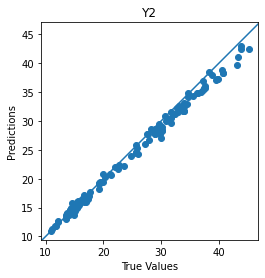

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)